Balanced classes: 5    1627
4    1625
0    1620
6    1617
2    1614
3    1611
1    1590
Name: count, dtype: int64


C:\Users\Madeeha Ruhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Madeeha Ruhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



SELECTED FEATURES:
Weight_kg
BP
Glucose
HeartRate
Stamina
Disease
Severity
DailyCalories

Total selected features: 8

CLASSIFICATION REPORT

                        precision    recall  f1-score   support

Anti-inflammatory diet       1.00      1.00      1.00        21
  Balanced Indian diet       1.00      1.00      1.00       407
  Calorie deficit diet       0.96      0.96      0.96        50
     High-protein diet       0.83      0.91      0.87        11
Low-carb diabetic diet       0.97      0.97      0.97        39
    Low-salt DASH diet       0.98      0.93      0.96        46
    Mediterranean diet       0.89      0.92      0.91        26

              accuracy                           0.98       600
             macro avg       0.95      0.96      0.95       600
          weighted avg       0.99      0.98      0.99       600



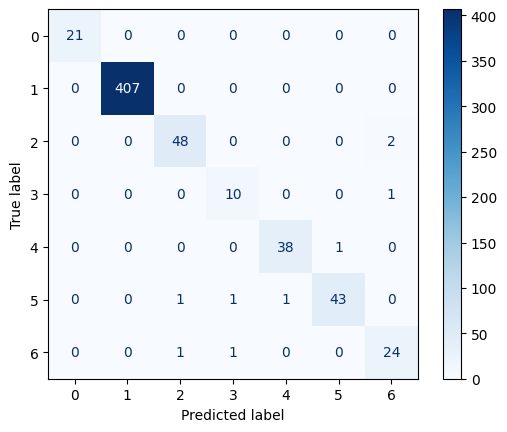


Model saved as: rf_diet_model.pkl
Feature selector saved as: feature_selector.pkl
Encoders saved.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib     # 🚀 For saving model

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ------------------------------
# LOAD DATA
# ------------------------------
df = pd.read_csv("diet_dataset_correlated_realprevalence_3000.csv")
df = df.drop("BMI", axis=1)

target = "DietRecommendation"

# ------------------------------
# ENCODING
# ------------------------------
X = df.drop(columns=[target]).copy()
y_raw = df[target].copy()

non_num = X.select_dtypes(include=["object"]).columns
encoders = {}

for c in non_num:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])
    encoders[c] = le

target_le = LabelEncoder()
y = target_le.fit_transform(y_raw)

# ------------------------------
# TRAIN-TEST SPLIT
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# ------------------------------
# SMOTE-TOMEK (Better than ADASYN)
# ------------------------------
smt = SMOTETomek(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smt.fit_resample(X_train, y_train)

print("Balanced classes:", pd.Series(y_train_bal).value_counts())

# ------------------------------
# FEATURE SELECTION WITH RANDOM FOREST
# ------------------------------
selector_rf = RandomForestClassifier(
    n_estimators=200, max_depth=6, random_state=RANDOM_STATE, n_jobs=-1
)
selector_rf.fit(X_train_bal, y_train_bal)

selector = SelectFromModel(selector_rf, threshold="median", prefit=True)
X_train_sel = selector.transform(X_train_bal)
X_test_sel = selector.transform(X_test)

# 🔥 Print Selected Feature Names
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]

print("\n==============================")
print("SELECTED FEATURES:")
print("==============================")
for f in selected_features:
    print(f)

print("\nTotal selected features:", len(selected_features))

# ------------------------------
# FINAL RANDOM FOREST (Low Overfitting)
# ------------------------------
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train_sel, y_train_bal)
y_pred = rf.predict(X_test_sel)

# ------------------------------
# EVALUATION
# ------------------------------
print("\nCLASSIFICATION REPORT\n")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

# ------------------------------
# SAVE TRAINED MODEL + SELECTOR + ENCODERS
# ------------------------------
joblib.dump(rf, "rf_diet_model.pkl")
joblib.dump(selector, "feature_selector.pkl")
joblib.dump(encoders, "label_encoders.pkl")
joblib.dump(target_le, "target_encoder.pkl")

print("\nModel saved as: rf_diet_model.pkl")
print("Feature selector saved as: feature_selector.pkl")
print("Encoders saved.")
